In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import argparse
import logging
import math
import os
import random
from pathlib import Path

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, deprecate, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

In [3]:
args = argparse.Namespace(
    input_pertubation=0.1,
    pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5",
    revision=None,
    dataset_name="lambdalabs/pokemon-blip-captions",
    dataset_config_name=None,
    train_data_dir=None,
    image_column="image",
    caption_column="text",
    max_train_samples=None,
    validation_prompts=None,
    output_dir="sd-pokemon-model",
    cache_dir="./dataset",
    seed=None,
    resolution=224,
    center_crop=False,
    random_flip=False,
    train_batch_size=1,
    num_train_epochs=100,
    max_train_steps=15000,
    gradient_accumulation_steps=1,
    gradient_checkpointing=False,
    learning_rate=1e-05,
    scale_lr=False,
    lr_scheduler="constant",
    lr_warmup_steps=0,
    snr_gamma=None,
    use_8bit_adam=False,
    allow_tf32=False,
    use_ema=False,
    non_ema_revision=None,
    dataloader_num_workers=0,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_weight_decay=1e-2,
    adam_epsilon=1e-08,
    max_grad_norm=1.0,
    push_to_hub=False,
    hub_token=None,
    hub_model_id=None,
    logging_dir="logs",
    mixed_precision="fp16",
    report_to="tensorboard",
    local_rank=-1,
    checkpointing_steps=500,
    checkpoints_total_limit=None,
    resume_from_checkpoint=None,
    enable_xformers_memory_efficient_attention=True,
    noise_offset=0,
    validation_epochs=5,
    tracker_project_name="text2image-fine-tune"
)


In [4]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [74]:
dataset_name = "lambdalabs/pokemon-blip-captions"

In [75]:
dataset = load_dataset(
        args.dataset_name,
        args.dataset_config_name,
        cache_dir=args.cache_dir,
    )

Found cached dataset parquet (/remote-home/songtianwei/research/diffusion_model_my/sh/text-to-image/train_finetuned/dataset/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
        transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [77]:
train_dataset = dataset["train"]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280 at 0x7FF94024B190>, 'text': 'a drawing of a green pokemon with red eyes'}


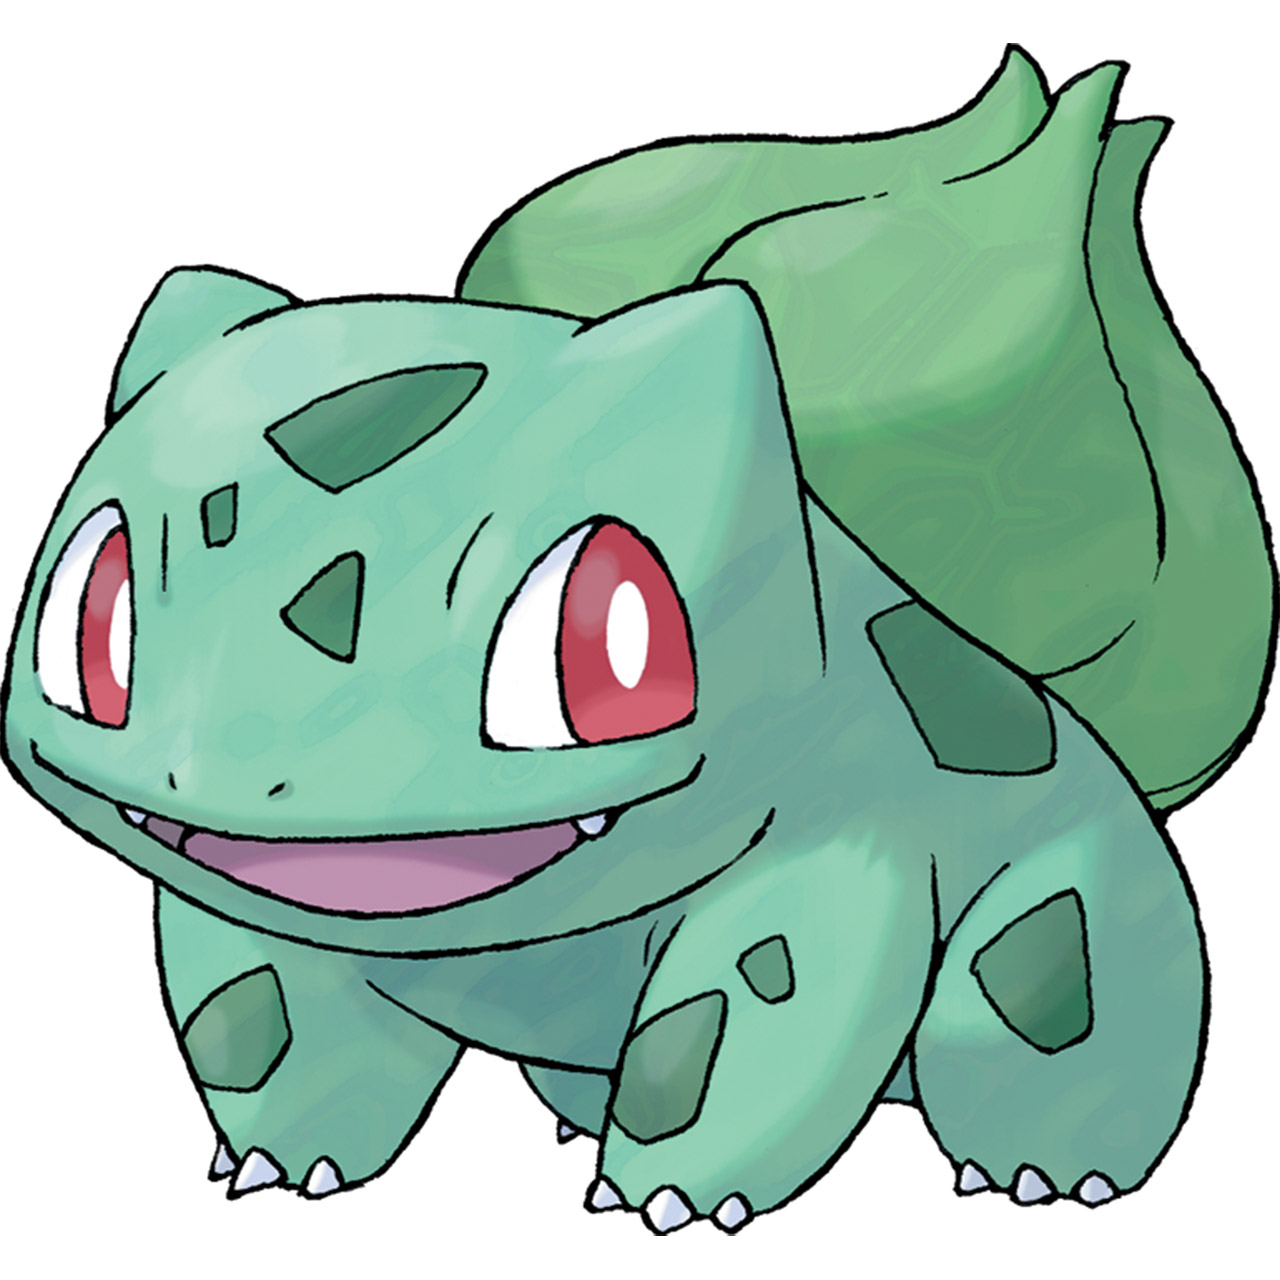

a drawing of a green pokemon with red eyes


In [78]:
for data in train_dataset:
    print(data)
    img = data["image"]
    prompt = data["text"]
    img.show()
    print(prompt)
    img.save("test_pokemen.jpg")
    
    break

In [79]:
# Preprocessing the datasets.
# We need to tokenize input captions and transform the images.
def tokenize_captions(examples, is_train=True):
    captions = []
    for caption in examples["text"]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids

In [80]:
def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples

In [81]:
train_dataset = dataset["train"].with_transform(preprocess_train)

In [82]:
for data in train_dataset:
    print(data)
    input_tensor = data["pixel_values"]
    input_ids = data["input_ids"]
    print(input_tensor.shape)  # [3,512,512]
    print(input_ids.shape)# [77]
    break

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280 at 0x7FF94026FAC0>, 'text': 'a drawing of a green pokemon with red eyes', 'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), 'input_ids': tensor([49406,   320,  3610,   539,

In [83]:
unet_pretrained = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.non_ema_revision
)

In [84]:
! ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
dataset		    test_pokemen.jpg		   train_text_to_image.py
mytrain.ipynb	    text-to-image-fine-tuning.sh   unet
sd-model-finetuned  text-to-image-inference.ipynb
sd-pokemon-model    text-to-image.ipynb


In [85]:
unet_cofnig = {
    "act_fn": "silu",
  "attention_head_dim": 8,
  "block_out_channels": [
    320,
    640,
    1280,
    1280
  ],
  "center_input_sample": False,
  "cross_attention_dim": 768,
  "down_block_types": [
    "CrossAttnDownBlock2D",
    "CrossAttnDownBlock2D",
    "CrossAttnDownBlock2D",
    "DownBlock2D"
  ],
  "downsample_padding": 1,
  "flip_sin_to_cos": True,
  "freq_shift": 0,
  "in_channels": 4,
  "layers_per_block": 2,
  "mid_block_scale_factor": 1,
  "norm_eps": 1e-05,
  "norm_num_groups": 32,
  "out_channels": 4,
  "sample_size": 64,
  "up_block_types": [
    "UpBlock2D",
    "CrossAttnUpBlock2D",
    "CrossAttnUpBlock2D",
    "CrossAttnUpBlock2D"
  ]
}


In [86]:
from PIL import Image

In [87]:
test_image = Image.open("test_pokemen.jpg")

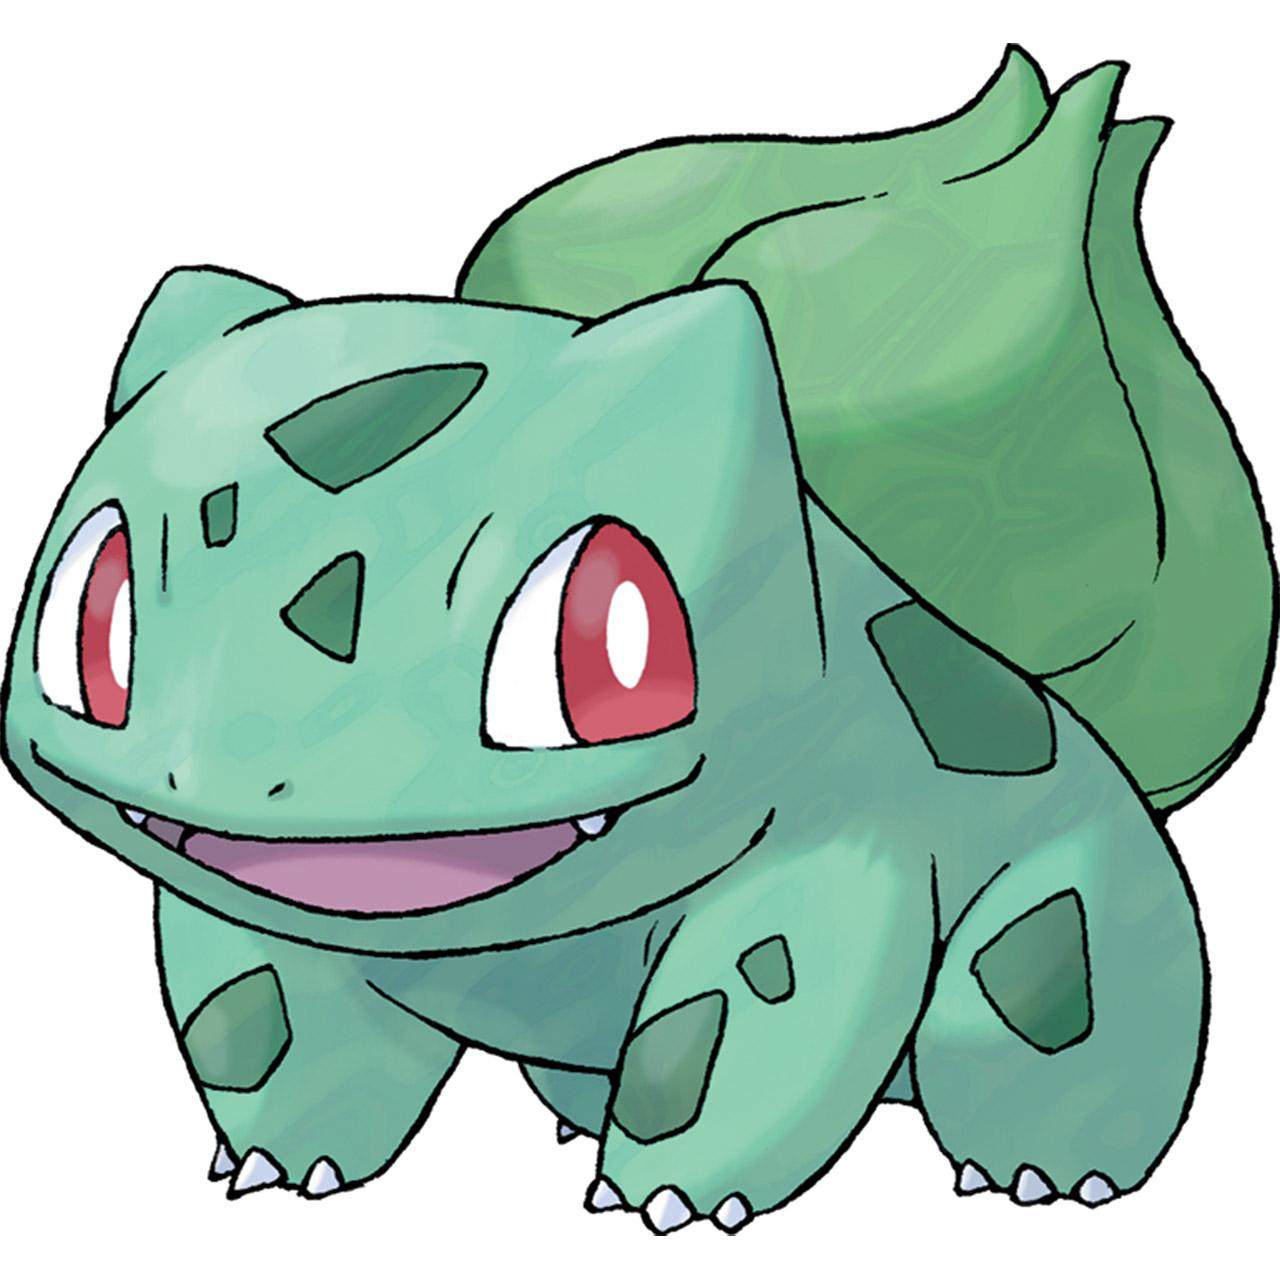

In [88]:
test_image.show()

In [89]:
def show_img_from_tensor(img_tensor,size=None):
    import torch
    import matplotlib.pyplot as plt
    from torchvision import transforms

    # 创建一个指定大小的图像
    if size is not None:
        resize_transform = transforms.Resize(size)
        img_tensor = resize_transform(img_tensor)
    
    input = (img_tensor / 2 + 0.5).clamp(0, 1)  # input ~ N(0.5,0.25)
    # 将噪音张量转换为NumPy数组
    noise_np = input.cpu().numpy()
    print(noise_np.shape)
    print(input.shape)
    # 将噪音图像可视化
    plt.imshow(noise_np.squeeze().transpose(1, 2, 0))  # input can be double(0-1) or pixiv value(0-255)
    plt.axis('off')
    plt.show()


In [90]:
img_tensor = train_transforms(test_image)  # [3,512,512]

In [91]:
text = "a drawing of a green pokemon with red eyes"

In [92]:
unet = UNet2DConditionModel(**unet_cofnig)

In [93]:
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")

In [167]:
# Freeze vae.encoder and text_encoder
vae.encoder.requires_grad_(False)
text_encoder.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [197]:
# batch_img_input = torch.ones((1,3,args.resolution,args.resolution))
batch_img_input = img_tensor.unsqueeze(0)
# batch_text_input = torch.ones((1,77,768))
batch_text_input = torch.ones((1,77,768))

In [198]:
vae_encoding = vae.encode(batch_img_input).latent_dist.sample()

In [199]:
var_decoding = vae.decode(vae_encoding)

In [200]:
var_decoding.sample.shape

torch.Size([1, 3, 224, 224])

In [201]:
batch_output = unet(vae_encoding,timestep=50,encoder_hidden_states=batch_text_input)

In [202]:
delta_im = batch_output.sample   # same shape with input

limit the norm of the batch output

In [203]:
norm_type = 'l2'
epsilon = 16

In [204]:
# if norm_type == 'l2':
#     temp = torch.norm(delta_im.view(delta_im.shape[0], -1), dim=1).view(-1, 1, 1, 1)
#     delta_im = delta_im * epsilon / temp
# else:
#     delta_im = torch.clamp(delta_im, -epsilon / 255, epsilon / 255)

In [205]:
# batch_output = vae_encoding + delta_im

In [206]:
batch_output = delta_im

In [207]:
vae_decoding = vae.decode(batch_output).sample

In [208]:
if norm_type == 'l2':
    temp = torch.norm(vae_decoding.view(delta_im.shape[0], -1), dim=1).view(-1, 1, 1, 1)
    vae_decoding = vae_decoding * epsilon / temp
else:
    vae_decoding = torch.clamp(vae_decoding, -epsilon / 255, epsilon / 255)

In [209]:
vae_decoding.shape

torch.Size([1, 3, 224, 224])

In [210]:
image_noise = batch_img_input + vae_decoding

(3, 224, 224)
torch.Size([3, 224, 224])


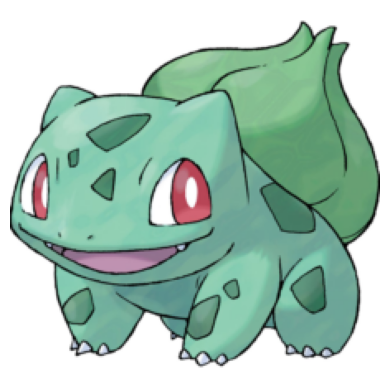

In [211]:
show_img_from_tensor(img_tensor)

(1, 3, 224, 224)
torch.Size([1, 3, 224, 224])


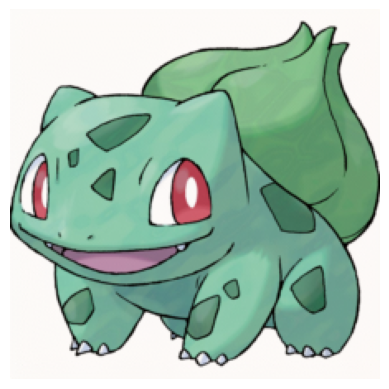

In [212]:
show_img_from_tensor(image_noise.detach())

In [213]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [215]:
image_features = model.get_image_features(image_noise)

In [216]:
image_features.shape

torch.Size([1, 512])

In [217]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [218]:
inputs = tokenizer([text], padding=True, return_tensors="pt")

In [219]:
inputs

{'input_ids': tensor([[49406,   320,  3610,   539,   320,  1901,  9528,   593,   736,  3095,
         49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [220]:
text_features = model.get_text_features(**inputs)

In [221]:
text_features.shape

torch.Size([1, 512])

In [222]:
# cosine similarity as logits
def cal_sim(text_features,image_features):
    import torch.nn as nn

    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    logit_scale = logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()
    
    return logits_per_image, logits_per_text

In [223]:
logit,_ = cal_sim(text_features,image_features)

In [224]:
logit

tensor([[4.8025]], grad_fn=<MmBackward0>)

In [225]:
optimizer_cls = torch.optim.AdamW

In [226]:
optimizer = optimizer_cls(
    unet.parameters(),
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

In [227]:
optimizer.zero_grad()

In [228]:
logit.backward()

In [229]:
print(unet.conv_in.weight.grad)

tensor([[[[ 1.3755e-03,  1.7048e-04,  6.0285e-04],
          [-6.6410e-04,  1.9727e-03, -1.6224e-03],
          [ 5.4940e-04, -1.4801e-04, -1.9744e-04]],

         [[ 2.2890e-03,  5.3907e-04, -4.5780e-04],
          [ 1.6709e-03,  2.1793e-05, -3.1002e-04],
          [ 2.3939e-03, -1.1342e-05,  1.4505e-04]],

         [[-2.2388e-03,  1.9791e-03,  2.7539e-04],
          [-5.3204e-04,  8.5957e-04,  1.9810e-04],
          [-3.5191e-04, -4.3949e-04,  1.0516e-03]],

         [[-5.3495e-04,  7.1103e-04,  5.3177e-05],
          [-3.3311e-03,  1.8008e-03, -1.3107e-03],
          [-9.5477e-04, -1.4087e-03, -1.0115e-03]]],


        [[[-4.8798e-04,  3.4300e-04, -2.3329e-03],
          [-4.3199e-04, -2.1417e-03,  2.1864e-05],
          [-2.4326e-03, -1.0523e-03, -2.1768e-03]],

         [[-2.3870e-03,  9.4855e-04,  6.9031e-05],
          [ 8.9844e-04,  1.1123e-04, -7.9040e-04],
          [-2.4332e-04, -6.5810e-04, -1.9164e-03]],

         [[ 1.0816e-03,  5.8312e-04, -1.9350e-03],
          [-1.062

In [159]:
optimizer.step()

In [234]:
vae.save_pretrained("./checkpoints/vae",is_main_process=True)

In [233]:
unet.save_pretrained("./checkpoints/unet",is_main_process=True)

In [55]:
from transformers import AutoTokenizer, CLIPTextModelWithProjection

model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

outputs = model(**inputs)
text_embeds = outputs.text_embeds

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModelWithProjection: ['vision_model.encoder.layers.3.layer_norm1.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_model.encoder.layers.7.layer_norm1.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.9.mlp.fc2.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.9.layer_norm1.bias', 'vision_model.encoder.layers.10.mlp.fc1.weight', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.bias', 'vision_model.encoder.layer

In [71]:
batch_text_input.shape

torch.Size([1, 77, 768])

In [45]:
tokenizer = CLIPTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision
)

In [53]:
clip_feature_extractor = transformers.CLIPImageProcessor()

In [54]:
batch_img_with_noise = torch.clamp(batch_img_input,0,1)

In [62]:
batch_img_with_noise.shape

torch.Size([1, 3, 64, 64])

In [59]:
from transformers import AutoTokenizer, CLIPModel

In [60]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [73]:
temp_input = torch.ones((1,3,64,64))

In [74]:
batch_features = model.get_image_features(temp_input)

RuntimeError: The size of tensor a (5) must match the size of tensor b (50) at non-singleton dimension 1

In [23]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")

image_features = model.get_image_features(**inputs)

In [25]:
image_features.shape  # [1,512]

torch.Size([1, 512])

In [70]:
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [34]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionModelWithProjection

model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
image_embeds = outputs.image_embeds

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.3.self_attn.k_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.7.self_attn.out_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.9.mlp.fc1.bias', 'text_model.encoder.layers.3.self_attn.q_proj.bias', 'text_model.encoder.layers.6.self_attn.q_proj.bias', 'text_model.encoder.layers.2.self_attn.q_proj.weight', 'text_model.encoder.layers.2.mlp.fc2.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.3.layer_norm1.weight', 'text_model.encoder.layers.6.mlp.fc2.bias', 'text_model.encoder.layers.4.layer_norm2.weight', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.5.mlp.fc1.weight', 'text_model.encoder.layers.2.layer_norm1.bias', 'text

AttributeError: 'function' object has no attribute 'shape'

In [40]:
inputs['pixel_values'].shape  # torch.Size([1, 3, 224, 224])

torch.Size([1, 3, 224, 224])

In [33]:
print(image_embeds.shape)

torch.Size([1, 512])


In [30]:
from transformers import AutoTokenizer, CLIPTextModelWithProjection

model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

outputs = model(**inputs)
text_embeds = outputs.text_embeds

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModelWithProjection: ['vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.layer_norm2.weight', 'vision_model.encoder.layers.8.layer_norm1.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.7.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.layer_norm1.weight', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.9.mlp.fc2.bias', 'vision_model.encoder.layers.10.mlp.fc1.bias', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.embeddings.patch_embedding.weight', 'vision_model.encod

In [31]:
print(text_embeds.shape)

torch.Size([2, 512])


In [91]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

In [92]:
temp_data = torch.randn((1,4,64,64))

(1, 4, 64, 64)
torch.Size([1, 4, 64, 64])


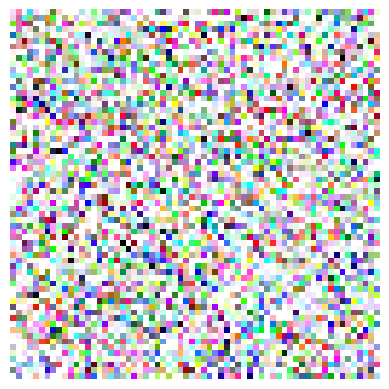

In [93]:
show_img_from_tensor(temp_data)

In [110]:
temp_data = torch.randn((1,4,64,64))
vae_output = vae.decode(temp_data).sample  # [1,3,224,224]

In [111]:
import matplotlib.pyplot as plt
import torch

(1, 3, 512, 512)
torch.Size([1, 3, 512, 512])


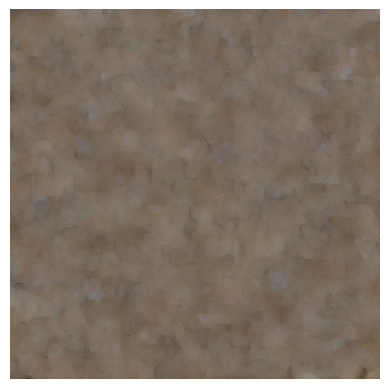

In [112]:
vae_output = vae_output.detach()
show_img_from_tensor(vae_output)